#### Imports

In [13]:
%matplotlib inline
from urllib.request import urlopen
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import graphviz
import matplotlib.gridspec as gridspec

plt.style.use('fivethirtyeight')
from joblib import parallel_backend
from imblearn.under_sampling import NearMiss, InstanceHardnessThreshold, OneSidedSelection, CondensedNearestNeighbour
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

Loading pickle file, setting X and y.

In [20]:
with urlopen("https://metis-project-storage.s3-us-west-1.amazonaws.com/select_cols.p") as read_file:
    selected_columns = pickle.load(read_file)
    
X, y = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), selected_columns.filter(['>50K'])

In [21]:
X

,EDUC,UHRSWORK,OCC,VALUEH,DEGFIELD,AGE,SEX,TRANWORK
2292,6.0,40.0,440.0,130000.0,0.0,70.0,1.0,70.0
2293,6.0,40.0,4850.0,130000.0,0.0,71.0,2.0,10.0
2294,6.0,40.0,9130.0,50000.0,0.0,60.0,1.0,10.0
2295,8.0,40.0,5730.0,50000.0,0.0,50.0,2.0,10.0
2297,6.0,0.0,0.0,50000.0,0.0,60.0,2.0,0.0
...,...,...,...,...,...,...,...,...
3214529,8.0,30.0,3220.0,275000.0,0.0,55.0,2.0,10.0
3214530,6.0,0.0,3870.0,275000.0,0.0,77.0,1.0,0.0
3214531,6.0,40.0,5000.0,260000.0,0.0,41.0,1.0,10.0
3214532,10.0,50.0,2310.0,260000.0,36.0,34.0,2.0,10.0


8 columns feels a little lonely. Let's bring in some dummies (and deal with the categorical variables).

In [6]:
edu = pd.get_dummies(X['EDUC'], prefix='edu')
occ = pd.get_dummies(X['OCC'], prefix='occ')
degfield = pd.get_dummies(X['DEGFIELD'], prefix='deg')
sex = pd.get_dummies(X['SEX'], prefix='sex', drop_first=True)
leftover = X.drop(columns=['EDUC', 'OCC', 'DEGFIELD', 'SEX'])
X = pd.concat([leftover, occ, sex, degfield, edu], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X

,UHRSWORK,VALUEH,AGE,TRANWORK,occ_0.0,occ_10.0,occ_20.0,occ_40.0,occ_51.0,occ_52.0,...,edu_1.0,edu_2.0,edu_3.0,edu_4.0,edu_5.0,edu_6.0,edu_7.0,edu_8.0,edu_10.0,edu_11.0
2292,40.0,130000.0,70.0,70.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2293,40.0,130000.0,71.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2294,40.0,50000.0,60.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2295,40.0,50000.0,50.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2297,0.0,50000.0,60.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214529,30.0,275000.0,55.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3214530,0.0,275000.0,77.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3214531,40.0,260000.0,41.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3214532,50.0,260000.0,34.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Much better. Now, to deal with the class imbalance... (really just for demonstration purposes. We will see the difference in performance between the raw imbalanced data and the resampled data).

In [8]:
import tqdm

nm1 = NearMiss(version=1, sampling_strategy='auto', n_jobs=-1)

In [11]:
resampled_X, resampled_y = nm1.fit_resample(X_train, y_train)

KeyboardInterrupt: 

Scaling train and test set.

In [12]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xr_train_scaled = std.fit_transform(resampled_X)
X_test_scaled = std.fit_transform(X_test)

NameError: name 'resampled_X' is not defined

## Logistic Regression

We'll start with a classic, Logistic Regression.

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


The score for logistic regression is
Training:  66.74%
Test set:  66.76%


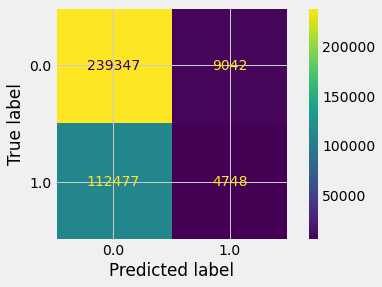

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test, y_test)))
plot_confusion_matrix(lr, X_test, y_test, values_format='d')

In [14]:
y_predict = lr.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.3443,   Recall: 0.0405


Not a terrible r2, and the similarity between train and test scores indicates low overfitting? However, the precision and recall scores are abysmal. In the confusion matrix we can see that there are almost twice as many false negatives as true negatives. We can also see this later on the ROC curve plot.

Let's try it with some variations - resampled, scaled, and balanced by parameter.

---

Here's with regular data, adjusting for class imbalance by passing in weight_class='balanced' (this makes the model take much longer to run, apparently due to the class weights):

In [9]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test, y_test)))

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


The score for logistic regression is
Training:  32.14%
Test set:  32.06%


Pretty bad! Let's try with the scaled set (takes much longer).

In [10]:
lr = LogisticRegression(n_jobs=-1)
lr.fit(X_train_scaled, y_train)

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(n_jobs=-1)

In [11]:
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test_scaled, y_test)))

The score for logistic regression is
Training:  82.16%
Test set:  82.13%


Great improvement on the R2 score.

In [12]:
y_predict = lr.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.7512,   Recall: 0.6620


Also a decent improvement on precision and recall.

## Extra Trees

In [13]:
et = ExtraTreesClassifier(n_jobs=-1)
et.fit(X_train, y_train)
print("The r2 score for extra trees is")
print("Training: {:6.2f}%".format(100*et.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*et.score(X_test, y_test)))

<ipython-input-13-d23229294163>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  et.fit(X_train, y_train)


The r2 score for extra trees is
Training:  97.55%
Test set:  80.64%


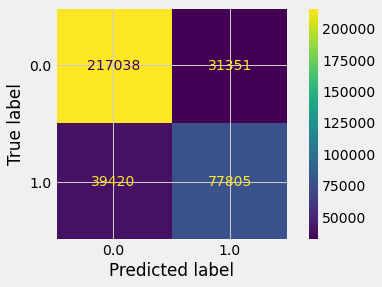

In [14]:
plot_confusion_matrix(et, X_test, y_test, values_format='d')

In [15]:
y_predict = et.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.7128,   Recall: 0.6637


Extra Trees and Random Forest are both ensemble models based off Decision Tree, which explains why their results are so similar.

## Random Forest

In [6]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rf.score(X_test, y_test)))

<ipython-input-6-732b05d4d817>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


The r2 score for random forest is
Training:  97.55%
Test set:  81.42%


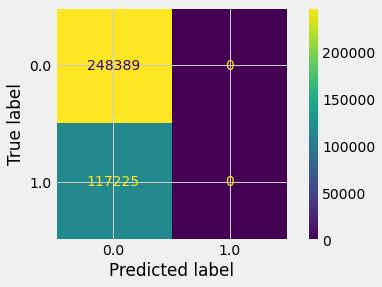

In [17]:
plot_confusion_matrix(rf, X_test_scaled, y_test, values_format='d')

In [18]:
y_predict = rf.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.7283,   Recall: 0.6718


Let's try Random Forest with scaled X:

In [19]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_scaled, y_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*rf.score(X_test_scaled, y_test)))

<ipython-input-19-0d21713ce857>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled, y_train)


The r2 score for random forest is
Training:  97.55%
Test set:  81.42%


Interestingly, R2 scores for Random Forest are virtually identical when using scaled and unscaled features. Apparently tree-based models do not require normalization, because the splits between nodes will be the same regardless of scale.

In [20]:
y_predict = rf.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.7272,   Recall: 0.6729


# KNN

In [21]:
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn.fit(X_train, y_train)
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

<ipython-input-21-891d3e17a4c9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(X_train, y_train)


Training:  96.70%
Test set:  74.61%


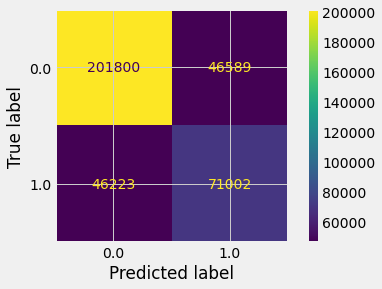

In [22]:
plot_confusion_matrix(knn, X_test, y_test, values_format='d')

In [23]:
y_predict = knn.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.6038,   Recall: 0.6057


KNN has decent results, though not as good as Random Forest or Logistic Regression. With the extremely long wait times to run this model, it is a clear loser here.

roc_auc_score for Random Forest:  0.12565226582842426
roc_auc_score for Logistic Regression:  0.4346812504479227


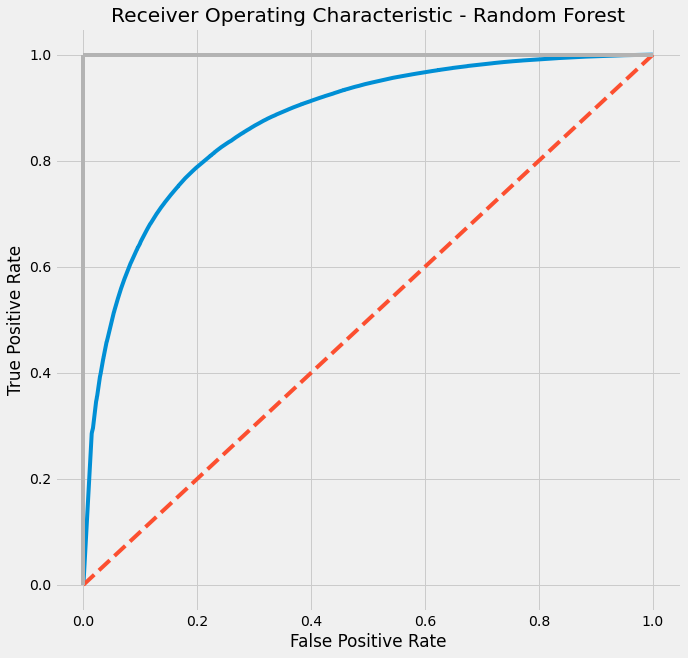

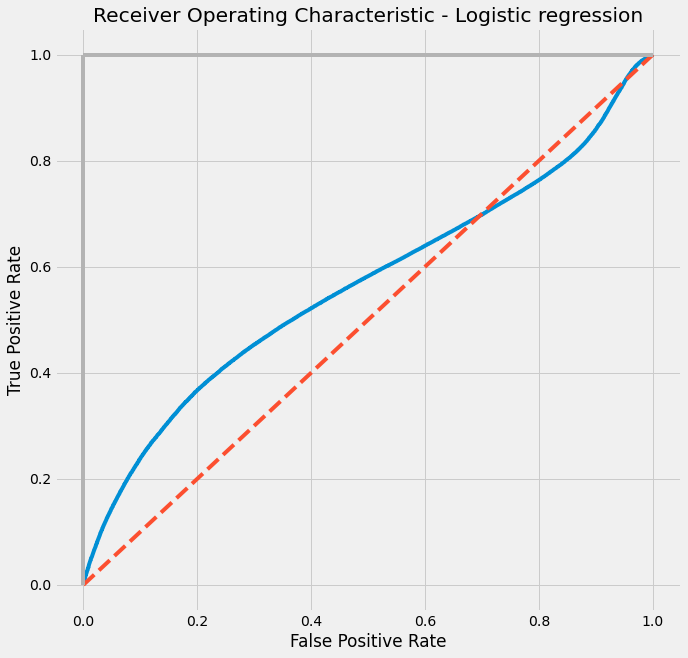

In [10]:
y_score1 = rf.predict_proba(X_test)[:, 0]
y_score2 = lr.predict_proba(X_test)[:, 0]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest: ',
     roc_auc_score(y_test, y_score1))
print('roc_auc_score for Logistic Regression: ',
      roc_auc_score(y_test, y_score2))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(true_positive_rate1, false_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(true_positive_rate2, false_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

roc_auc_score for Extra Trees:  0.1479977889784514
roc_auc_score for KNN:  0.29093737707549017


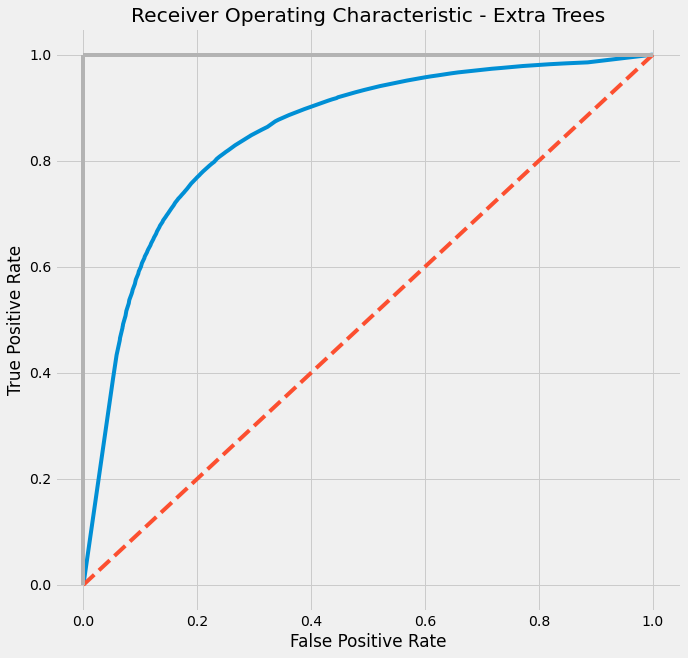

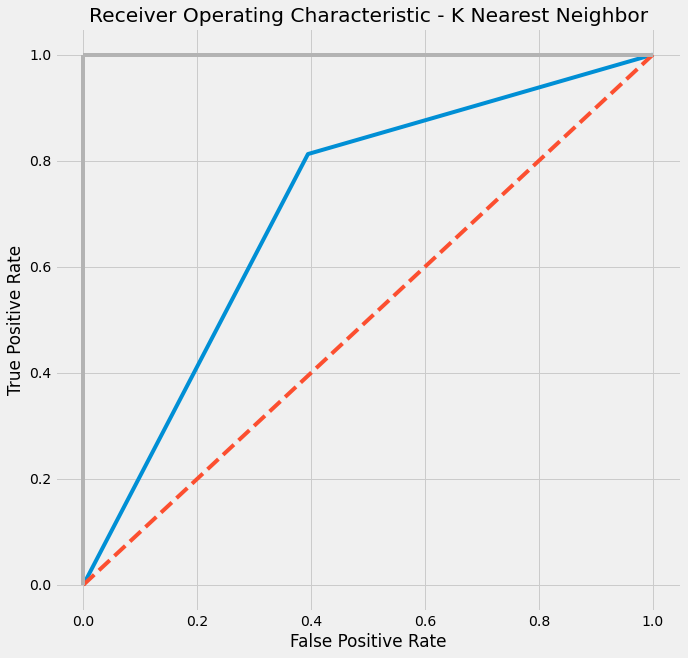

In [25]:
y_score3 = et.predict_proba(X_test)[:, 0]
y_score4 = knn.predict_proba(X_test)[:, 0]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score3)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score4)
print('roc_auc_score for Extra Trees: ',
     roc_auc_score(y_test, y_score3))
print('roc_auc_score for KNN: ',
      roc_auc_score(y_test, y_score4))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Extra Trees')
plt.plot(true_positive_rate1, false_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - K Nearest Neighbor')
plt.plot(true_positive_rate2, false_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Although Logistic Regression technically has a slightly higher R2 score than Random Forest, the ROC curve plot looks horrendous - it's indistinguishable from the 50/50 diagonal line. Random Forest has a beautiful bump.

# Random Forest Wins!
---

### Bonus: XGBoost

In [5]:
eval_metrics = ['rmse', 'rmsle', 'mae', 'logloss', 'error', 'auc', 'aucpr', 'map', 'poisson-nloglik']

for metric in eval_metrics:
    clf_xgb = xgb.XGBClassifier(
                                objective='binary:logistic',
                                missing=None,
                                seed=42,
                                tree_method='gpu_hist',
                                verbosity=3,
                                )
    
    clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric=metric, eval_set=[(X_test, y_test)])

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[13:34:40] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:1061: [GPU Hist]: Configure
[13:34:40] DEBUG: /workspace/src/common/device_helpers.cu:38: Running nccl init on: 10.0
[13:34:42] ======== Monitor: DenseCuts ========
[13:34:42] Init: 0.004874s, 1 calls @ 4874us

[13:34:42] ======== Monitor: HistogramCuts ========
[0]	validation_0-rmse:0.43902
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.40531
[2]	validation_0-rmse:0.38627
[3]	validation_0-rmse:0.37547
[4]	validation_0-rmse:0.36908
[5]	validation_0-rmse:0.36540
[6]	validation_0-rmse:0.36288
[7]	validation_0-rmse:0.36113
[8]	validation_0-rmse:0.35974
[9]	validation_0-rmse:0.35883
[10]	validation_0-rmse:0.35814
[11]	validation_0-rmse:0.35746
[12]	validation_0-rmse:0.35697
[13]	validation_0-rmse:0.35651
[14]	validation_0-rmse:0.35610
[15]	validation_0-rmse:0.35562
[16]	validation_0-rmse:0.35518
[17]	validation_0-rmse:0.35475
[18]	validation_0-rmse:0.35442
[19]	validation_0-rmse:0.35406
[20]

[65]	validation_0-rmsle:0.24318
[66]	validation_0-rmsle:0.24313
[67]	validation_0-rmsle:0.24307
[68]	validation_0-rmsle:0.24301
[69]	validation_0-rmsle:0.24297
[70]	validation_0-rmsle:0.24291
[71]	validation_0-rmsle:0.24287
[72]	validation_0-rmsle:0.24281
[73]	validation_0-rmsle:0.24277
[74]	validation_0-rmsle:0.24273
[75]	validation_0-rmsle:0.24267
[76]	validation_0-rmsle:0.24262
[77]	validation_0-rmsle:0.24257
[78]	validation_0-rmsle:0.24254
[79]	validation_0-rmsle:0.24250
[80]	validation_0-rmsle:0.24246
[81]	validation_0-rmsle:0.24242
[82]	validation_0-rmsle:0.24239
[83]	validation_0-rmsle:0.24235
[84]	validation_0-rmsle:0.24231
[85]	validation_0-rmsle:0.24226
[86]	validation_0-rmsle:0.24223
[87]	validation_0-rmsle:0.24219
[88]	validation_0-rmsle:0.24217
[89]	validation_0-rmsle:0.24213
[90]	validation_0-rmsle:0.24210
[91]	validation_0-rmsle:0.24207
[92]	validation_0-rmsle:0.24204
[93]	validation_0-rmsle:0.24201
[94]	validation_0-rmsle:0.24197
[95]	validation_0-rmsle:0.24195
[96]	val

[13:35:59] ======== Monitor: Learner ========
[13:35:59] ======== Monitor:  ========
[13:35:59] ======== Device 0 Memory Allocations:  ========
[13:35:59] Peak memory usage: 5795MiB
[13:35:59] Number of allocations: 46183
[13:35:59] ======== Monitor:  ========
[13:35:59] ======== NCCL Statistics========
[13:35:59] AllReduce calls: 0
[13:35:59] AllReduce total MiB communicated: 0
[13:36:12] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:1061: [GPU Hist]: Configure
[13:36:12] DEBUG: /workspace/src/common/device_helpers.cu:38: Running nccl init on: 10.0
[13:36:14] ======== Monitor: DenseCuts ========
[13:36:14] Init: 0.004867s, 1 calls @ 4867us

[13:36:14] ======== Monitor: HistogramCuts ========
[0]	validation_0-logloss:0.57641
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.51253
[2]	validation_0-logloss:0.47386
[3]	validation_0-logloss:0.44929
[4]	validation_0-logloss:0.43305
[5]	validation_0-logloss:0.42225
[6]	validation_0-logloss:0.4147

[43]	validation_0-error:0.17546
[44]	validation_0-error:0.17524
[45]	validation_0-error:0.17521
[46]	validation_0-error:0.17503
[47]	validation_0-error:0.17490
[48]	validation_0-error:0.17478
[49]	validation_0-error:0.17462
[50]	validation_0-error:0.17453
[51]	validation_0-error:0.17448
[52]	validation_0-error:0.17430
[53]	validation_0-error:0.17418
[54]	validation_0-error:0.17400
[55]	validation_0-error:0.17384
[56]	validation_0-error:0.17383
[57]	validation_0-error:0.17371
[58]	validation_0-error:0.17363
[59]	validation_0-error:0.17356
[60]	validation_0-error:0.17347
[61]	validation_0-error:0.17332
[62]	validation_0-error:0.17330
[63]	validation_0-error:0.17312
[64]	validation_0-error:0.17311
[65]	validation_0-error:0.17305
[66]	validation_0-error:0.17297
[67]	validation_0-error:0.17285
[68]	validation_0-error:0.17277
[69]	validation_0-error:0.17270
[70]	validation_0-error:0.17259
[71]	validation_0-error:0.17244
[72]	validation_0-error:0.17249
[73]	validation_0-error:0.17225
[74]	val

[13:37:31] ======== Monitor: Learner ========
[13:37:31] ======== Monitor:  ========
[13:37:31] ======== Device 0 Memory Allocations:  ========
[13:37:31] Peak memory usage: 5795MiB
[13:37:31] Number of allocations: 94261
[13:37:31] ======== Monitor:  ========
[13:37:31] ======== NCCL Statistics========
[13:37:31] AllReduce calls: 0
[13:37:31] AllReduce total MiB communicated: 0
[13:37:44] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:1061: [GPU Hist]: Configure
[13:37:44] DEBUG: /workspace/src/common/device_helpers.cu:38: Running nccl init on: 10.0
[13:37:47] ======== Monitor: DenseCuts ========
[13:37:47] Init: 0.004821s, 1 calls @ 4821us

[13:37:47] ======== Monitor: HistogramCuts ========
[0]	validation_0-aucpr:0.74323
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.75857
[2]	validation_0-aucpr:0.76333
[3]	validation_0-aucpr:0.76577
[4]	validation_0-aucpr:0.76959
[5]	validation_0-aucpr:0.77068
[6]	validation_0-aucpr:0.77336
[7]	validation

[53]	validation_0-map:0.80385
[54]	validation_0-map:0.80412
[55]	validation_0-map:0.80438
[56]	validation_0-map:0.80457
[57]	validation_0-map:0.80476
[58]	validation_0-map:0.80495
[59]	validation_0-map:0.80517
[60]	validation_0-map:0.80529
[61]	validation_0-map:0.80547
[62]	validation_0-map:0.80570
[63]	validation_0-map:0.80585
[64]	validation_0-map:0.80610
[65]	validation_0-map:0.80624
[66]	validation_0-map:0.80637
[67]	validation_0-map:0.80650
[68]	validation_0-map:0.80664
[69]	validation_0-map:0.80685
[70]	validation_0-map:0.80703
[71]	validation_0-map:0.80714
[72]	validation_0-map:0.80730
[73]	validation_0-map:0.80741
[74]	validation_0-map:0.80756
[75]	validation_0-map:0.80767
[76]	validation_0-map:0.80783
[77]	validation_0-map:0.80795
[78]	validation_0-map:0.80803
[79]	validation_0-map:0.80816
[80]	validation_0-map:0.80830
[81]	validation_0-map:0.80844
[82]	validation_0-map:0.80856
[83]	validation_0-map:0.80859
[84]	validation_0-map:0.80878
[85]	validation_0-map:0.80895
[86]	valid

[98]	validation_0-poisson-nloglik:0.52303
[99]	validation_0-poisson-nloglik:0.52299
[13:39:04] ======== Monitor: Learner ========
[13:39:04] Configure: 0.000297s, 1 calls @ 297us

[13:39:04] EvalOneIter: 1.21225s, 100 calls @ 1212253us

[13:39:04] GetGradient: 0.013248s, 100 calls @ 13248us

[13:39:04] PredictRaw: 0.000303s, 100 calls @ 303us

[13:39:04] UpdateOneIter: 16.5428s, 100 calls @ 16542764us

[13:39:04] ======== Monitor: GBTree ========
[13:39:04] BoostNewTrees: 16.525s, 100 calls @ 16524982us

[13:39:04] CommitModel: 0.002414s, 100 calls @ 2414us

[13:39:04] ======== Device 0 Memory Allocations:  ========
[13:39:04] Peak memory usage: 5795MiB
[13:39:04] Number of allocations: 141168
[13:39:04] ======== Monitor: updater_gpu_hist ========
[13:39:04] InitData: 3.28183s, 100 calls @ 3281827us

[13:39:04] InitDataOnce: 3.2818s, 1 calls @ 3281796us

[13:39:04] InitHistogram: 1.7e-05s, 1 calls @ 17us

[13:39:04] Update: 16.5244s, 100 calls @ 16524421us

[13:39:04] UpdatePredictionC

In [6]:
y_predict = clf_xgb.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

[13:41:12] DEBUG: /workspace/src/tree/updater_gpu_hist.cu:1061: [GPU Hist]: Configure
[13:41:12] ======== Device 0 Memory Allocations:  ========
[13:41:12] Peak memory usage: 5795MiB
[13:41:12] Number of allocations: 141168
[13:41:12] ======== Monitor:  ========
[13:41:12] ======== NCCL Statistics========
[13:41:12] AllReduce calls: 0
[13:41:12] AllReduce total MiB communicated: 0
Default threshold:
Precision: 0.7607,   Recall: 0.6827


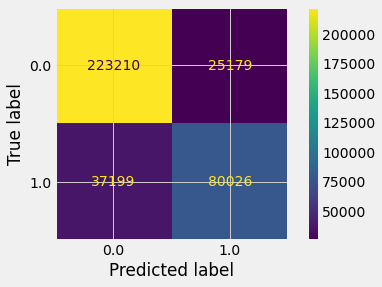

In [7]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d')